<a href="https://colab.research.google.com/github/helonayala/sysid/blob/main/excitation_signals.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Excitation signals

In this notebook we show some common excitation signals

* Multisine

* Swept-sine

* Filtered random-noise

The goal is to provide functions that generate excitation signals that have a pre-defined spectrum and amplitude.

## Functions and imports

In [61]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import chirp, square
import scipy.signal

def plot_spectrum(signal, fs, signal_name="Signal"):
    """
    Plots the spectrum of a given signal.

    Args:
        signal (np.array): The input signal.
        fs (float): The sampling frequency.
        signal_name (str, optional): Name of the signal for plot title.
                                     Defaults to "Signal".
    """
    n = len(signal)
    freq = np.fft.fftfreq(n, d=1/fs)
    spectrum = np.fft.fft(signal)

    plt.figure(figsize=(10,4))
    plt.plot(freq[:n//2], np.abs(spectrum[:n//2])) # One-sided spectrum, scaled
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Amplitude (absolute)")
    plt.title(f"Spectrum of {signal_name}")
    plt.grid(True)
    plt.xlim(0, fs/2) # Show up to Nyquist frequency
    plt.show()

def generate_multisine(fmin, fmax, amplitude, Ts, duration):
    """
    Generates a multisine signal with random phases using inverse FFT.

    Args:
        fmin (float): Minimum frequency (Hz).
        fmax (float): Maximum frequency (Hz).
        amplitude (float): Amplitude of the signal.
        Ts (float): Sampling time (s).
        duration (float): Total duration of the signal (s).

    Returns:
        tuple: (signal, time_vector)
               signal (np.array): The generated multisine signal.
               time_vector (np.array): The time vector.
    """
    fs = 1/Ts
    N = int(duration / Ts) # Number of samples
    time_vector = np.arange(N) * Ts

    freq_vector = np.fft.fftfreq(N, Ts)
    df = fs / N # Frequency resolution

    # Create an empty spectrum
    X = np.zeros(N, dtype=complex)

    # Determine the frequency bins to excite
    if fmin == 0: # Avoid issues with DC component if fmin is exactly 0
        start_index = 1
    else:
        start_index = int(np.ceil(fmin / df))
    end_index = int(np.floor(fmax / df))

    if start_index >= end_index:
        raise ValueError("fmax must be greater than fmin and the frequency range "
                         "must allow for at least one frequency bin.")
    if end_index > N // 2: # Ensure we don't go beyond Nyquist
        end_index = N // 2

    num_freqs = end_index - start_index + 1
    if num_freqs <= 0:
        raise ValueError("No frequency bins available in the specified range. "
                         "Try increasing duration or adjusting fmin/fmax.")

    # Assign amplitudes and random phases
    # For real signal, spectrum must be conjugate symmetric
    amp_per_freq = amplitude / np.sqrt(num_freqs) # Distribute amplitude

    for i in range(start_index, end_index + 1):
        phase = np.random.uniform(0, 2 * np.pi)
        X[i] = amp_per_freq * np.exp(1j * phase)
        if i > 0: # Avoid double counting DC or Nyquist if they were included
            X[N-i] = np.conjugate(X[i]) # Conjugate symmetry

    signal = np.fft.ifft(X).real * N # Scaling by N due to ifft definition
    signal = (signal / np.max(np.abs(signal))) * amplitude # Normalize and set amplitude

    print(f"Multisine: {num_freqs} excited frequencies from {freq_vector[start_index]:.2f} Hz to {freq_vector[end_index]:.2f} Hz.")
    plot_spectrum(signal, fs, "Multisine Signal")
    return signal, time_vector

def generate_chirp(fmin, fmax, amplitude, Ts, duration, method='linear'):
    """
    Generates a chirp (swept sine) signal.

    Args:
        fmin (float): Starting frequency (Hz).
        fmax (float): Ending frequency (Hz).
        amplitude (float): Amplitude of the signal.
        Ts (float): Sampling time (s).
        duration (float): Total duration of the signal (s).
        method (str, optional): Type of sweep ('linear', 'quadratic', 'logarithmic').
                                Defaults to 'linear'.

    Returns:
        tuple: (signal, time_vector)
               signal (np.array): The generated chirp signal.
               time_vector (np.array): The time vector.
    """
    fs = 1/Ts
    N = int(duration / Ts)
    time_vector = np.linspace(0, duration, N, endpoint=False)

    if fmin == 0 and method == 'logarithmic':
        print("Warning: fmin cannot be 0 for logarithmic chirp. Setting fmin to a small value (0.01 Hz).")
        fmin = 0.01 # Log chirp cannot start at 0 Hz

    signal = amplitude * chirp(time_vector, f0=fmin, f1=fmax, t1=duration, method=method)

    plot_spectrum(signal, fs, f"Chirp Signal ({method})")
    return signal, time_vector


def generate_butterworth_filtered_noise(
    fmin,
    fmax,
    amplitude,
    Ts,
    duration,
    num_realizations_output,
    filter_order=6
):
    """
    Generates filtered random noise using a Butterworth filter and averaging
    multiple realizations in the time domain.

    The output signal is the average of 'num_realizations_output' filtered
    Gaussian white noise sequences, scaled to the target RMS 'amplitude'.
    The spectrum of the output signal is plotted using the plot_spectrum function.

    Args:
        fmin (float): Minimum frequency for the filter (Hz). If 0 or very small,
                      a low-pass filter is designed.
        fmax (float): Maximum frequency for the filter (Hz).
        amplitude (float): Desired RMS amplitude of the final output signal.
        Ts (float): Sampling time (s).
        duration (float): Total duration of the signal (s).
        num_realizations_output (int): Number of noise realizations to average
                                       for the main output signal. Must be > 0.
        filter_order (int, optional): Order of the Butterworth filter.
                                      Defaults to 6.

    Returns:
        tuple: (signal, time_vector)
               signal (np.array): The generated filtered random noise.
               time_vector (np.array): The time vector.
               Returns (np.array([]), np.array([])) if parameters are invalid
               or lead to an empty signal.
    """
    fs = 1.0 / Ts
    N = int(duration / Ts)

    if N == 0:
        print("Warning: Duration and Ts result in zero samples. Returning empty arrays.")
        return np.array([]), np.array([])
    time_vector = np.arange(N) * Ts

    # --- Filter Design ---
    nyquist = fs / 2.0
    if not (0 <= fmin < fmax < nyquist): # Ensure fmax is strictly less than nyquist for stability
        # Relaxing fmax < nyquist to fmax <= nyquist if scipy.signal.butter handles it.
        # However, typically critical frequencies should be < nyquist.
        # For safety, let's keep fmax < nyquist.
        if fmax == nyquist: # Allow fmax to be exactly Nyquist for lowpass scenario
            if not (fmin <= 1e-6): # If it's bandpass with fmax=nyquist, it's problematic
                 raise ValueError(
                    f"Invalid frequency range for filter design. "
                    f"For bandpass, fmax must be strictly less than nyquist ({nyquist} Hz). "
                    f"Got fmin={fmin}, fmax={fmax}."
                )
        else:
             raise ValueError(
                f"Invalid frequency range for filter design. "
                f"Ensure 0 <= fmin < fmax < nyquist ({nyquist} Hz). "
                f"Got fmin={fmin}, fmax={fmax}."
            )


    if fmin <= 1e-6:  # Effectively low-pass if fmin is zero or very small
        Wn_crit = fmax
        btype_str = 'lowpass'
        filter_type_str = "Lowpass"
    else:  # Band-pass
        Wn_crit = [fmin, fmax]
        btype_str = 'bandpass'
        filter_type_str = "Bandpass"

    try:
        filter_b, filter_a = scipy.signal.butter(
            filter_order, Wn_crit, btype=btype_str, fs=fs, output='ba'
        )
    except ValueError as e:
        print(f"Error designing Butterworth filter: {e}")
        print(f"Parameters: order={filter_order}, Wn={Wn_crit}, btype='{btype_str}', fs={fs}")
        return np.array([]), np.array([])

    print(f"Designed Butterworth {filter_type_str} filter, order {filter_order}, Wn={Wn_crit} Hz.")

    # --- Generate Main Output Signal ---
    if num_realizations_output <= 0:
        raise ValueError("num_realizations_output must be positive.")

    sum_filtered_signals_output = np.zeros(N)
    for _ in range(num_realizations_output):
        white_noise = np.random.randn(N)  # Gaussian white noise, std=1
        # Apply filter using filtfilt for zero phase distortion
        filtered_noise = scipy.signal.filtfilt(filter_b, filter_a, white_noise)
        sum_filtered_signals_output += filtered_noise

    averaged_signal_raw = sum_filtered_signals_output / num_realizations_output

    # Scale to desired RMS amplitude
    current_rms = np.sqrt(np.mean(averaged_signal_raw**2))
    if current_rms > 1e-12: # Increased tolerance slightly for very low energy signals
        scaling_factor = amplitude / current_rms
        final_signal = averaged_signal_raw * scaling_factor
    else:
        if amplitude == 0:
            final_signal = np.zeros(N)
        else:
            final_signal = averaged_signal_raw  # Potentially all zeros
            print(
                f"Warning: Raw averaged signal (M={num_realizations_output}) has near zero RMS ({current_rms:.2e}). "
                f"Output signal may be zero or scaling inaccurate for target RMS {amplitude}."
            )
            # If signal is all zeros and target amplitude is non-zero, result remains zero.
            if np.all(final_signal == 0) and amplitude != 0 :
                print("The filter likely removed all signal components.")


    # --- Plot spectrum of the final output signal ---
    plot_title = f"Butterworth {filter_type_str} Noise (M={num_realizations_output})"
    plot_spectrum(final_signal, fs, signal_name=plot_title)

    return final_signal, time_vector



## Multisine (random phase)

--- Generating Multisine Signal ---
Multisine: 31 excited frequencies from 5.00 Hz to 20.00 Hz.


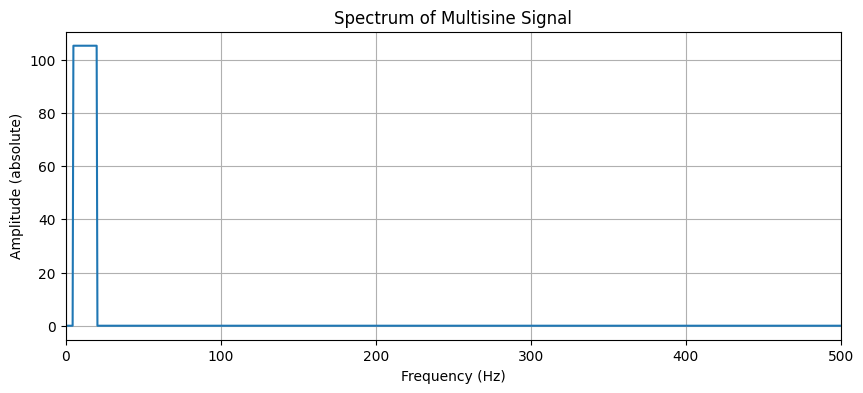

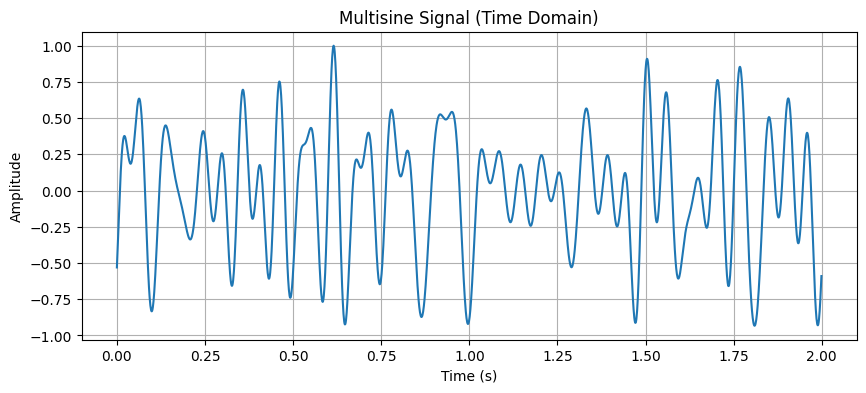

Multisine signal length: 2000, Time vector length: 2000



In [62]:
# Common parameters
FMIN = 5   # Hz
FMAX = 20  # Hz
AMPLITUDE = 1.0 # Volts or relevant unit
TS = 0.001  # Sampling time (s) -> fs = 1000 Hz
DURATION = 2.0 # Duration of signal (s)

print("--- Generating Multisine Signal ---")
multisine_signal, t_multi = generate_multisine(FMIN, FMAX, AMPLITUDE, TS, DURATION)
plt.figure(figsize=(10,4))
plt.plot(t_multi, multisine_signal)
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title("Multisine Signal (Time Domain)")
plt.grid(True)
plt.show()
print(f"Multisine signal length: {len(multisine_signal)}, Time vector length: {len(t_multi)}\n")


## Swept-sine

--- Generating Chirp Signal (Linear) ---


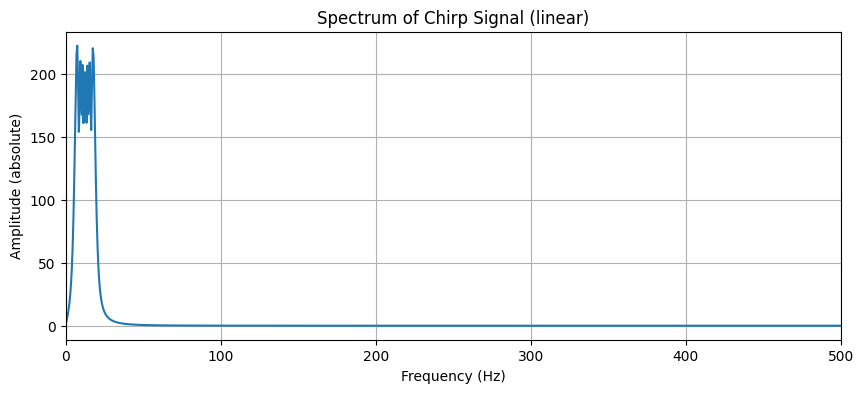

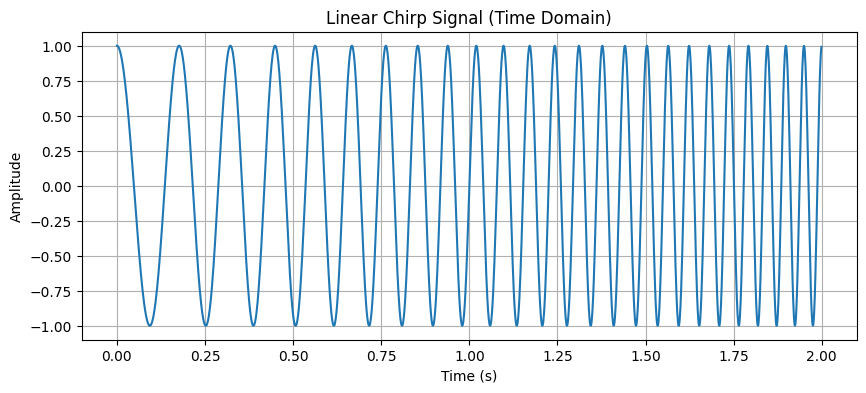

Linear Chirp signal length: 2000, Time vector length: 2000



In [63]:

print("--- Generating Chirp Signal (Linear) ---")
chirp_signal_lin, t_chirp_lin = generate_chirp(FMIN, FMAX, AMPLITUDE, TS, DURATION, method='linear')
plt.figure(figsize=(10,4))
plt.plot(t_chirp_lin, chirp_signal_lin)
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title("Linear Chirp Signal (Time Domain)")
plt.grid(True)
plt.show()
print(f"Linear Chirp signal length: {len(chirp_signal_lin)}, Time vector length: {len(t_chirp_lin)}\n")


--- Generating Chirp Signal (Logarithmic) ---


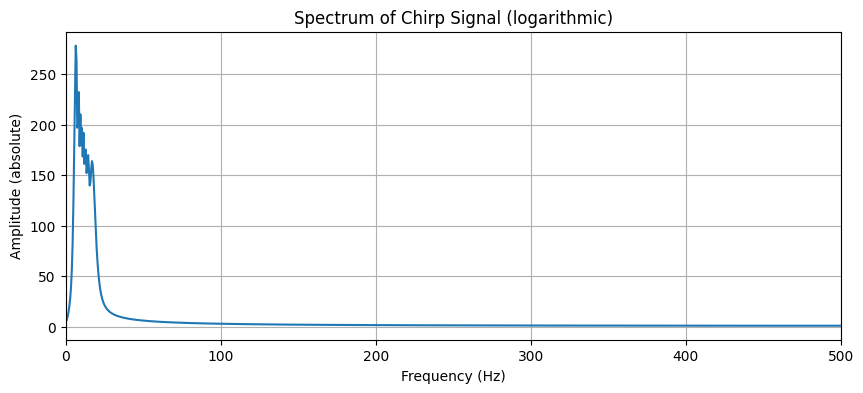

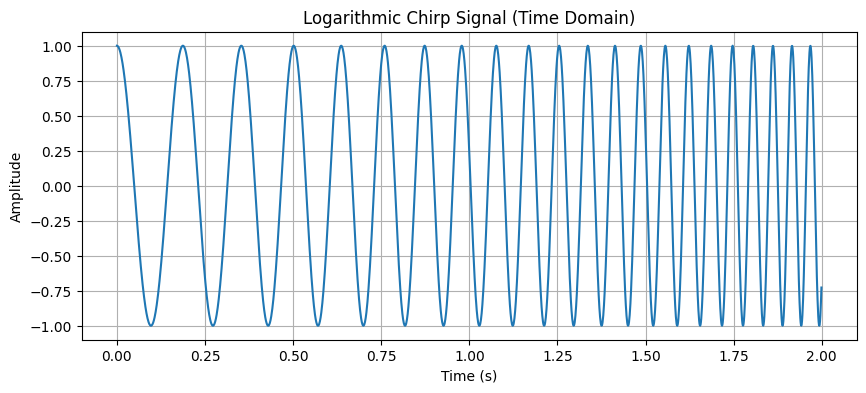

Log Chirp signal length: 2000, Time vector length: 2000



In [64]:

print("--- Generating Chirp Signal (Logarithmic) ---")
# For log chirp, fmin should ideally not be 0.
chirp_fmin_log = max(0.1, FMIN) # ensure fmin is not 0 for log chirp
chirp_signal_log, t_chirp_log = generate_chirp(chirp_fmin_log, FMAX, AMPLITUDE, TS, DURATION, method='logarithmic')
plt.figure(figsize=(10,4))
plt.plot(t_chirp_log, chirp_signal_log)
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title("Logarithmic Chirp Signal (Time Domain)")
plt.grid(True)
plt.show()
print(f"Log Chirp signal length: {len(chirp_signal_log)}, Time vector length: {len(t_chirp_log)}\n")



## Filtered random-noise


--- Generating Butterworth Band-Pass Filtered Noise (Output M=256) ---
Designed Butterworth Bandpass filter, order 6, Wn=[50, 150] Hz.


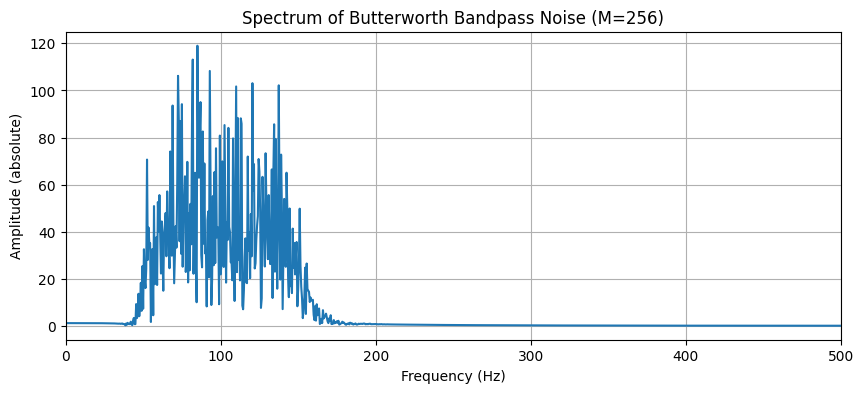

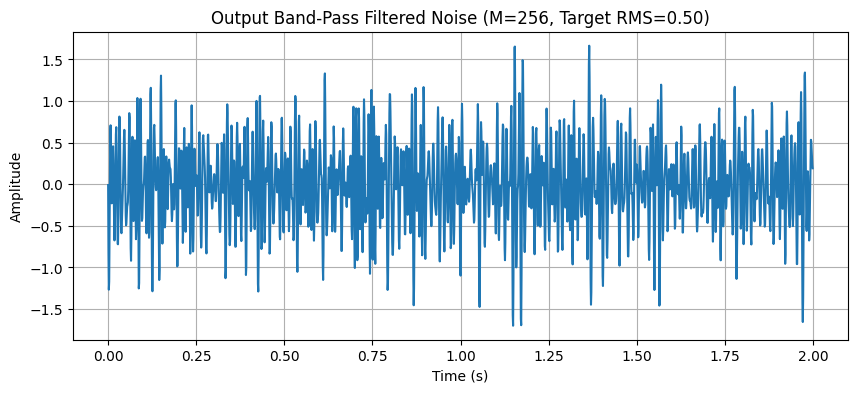

Output BP signal length: 2000
Desired RMS: 0.5000, Achieved RMS: 0.5000



In [65]:
# Common parameters
TS_EXAMPLE = 0.001  # Sampling time (s) -> fs = 1000 Hz
DURATION_EXAMPLE = 2.0 # Duration of signal (s)
FILTER_ORDER_EXAMPLE = 6

# --- Band-pass example ---
FMIN_BP = 50   # Hz
FMAX_BP = 150  # Hz
AMPLITUDE_BP = 0.5 # Target RMS for the output signal
NUM_REALIZATIONS_OUTPUT_BP = 256 # For the actual returned signal

print(f"\n--- Generating Butterworth Band-Pass Filtered Noise (Output M={NUM_REALIZATIONS_OUTPUT_BP}) ---")
bp_noise_signal, t_bp_noise = generate_butterworth_filtered_noise(
    FMIN_BP, FMAX_BP, AMPLITUDE_BP, TS_EXAMPLE, DURATION_EXAMPLE,
    NUM_REALIZATIONS_OUTPUT_BP, filter_order=FILTER_ORDER_EXAMPLE
)

plt.figure(figsize=(10, 4)) # Separate figure for time-domain plot
plt.plot(t_bp_noise, bp_noise_signal)
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title(f"Output Band-Pass Filtered Noise (M={NUM_REALIZATIONS_OUTPUT_BP}, Target RMS={AMPLITUDE_BP:.2f})")
plt.grid(True)
plt.show()
print(f"Output BP signal length: {len(bp_noise_signal)}")
achieved_rms_bp = np.sqrt(np.mean(bp_noise_signal**2)) if len(bp_noise_signal) > 0 else 0
print(f"Desired RMS: {AMPLITUDE_BP:.4f}, Achieved RMS: {achieved_rms_bp:.4f}\n")



--- Generating Butterworth Low-Pass Filtered Noise (Output M=20) ---
Designed Butterworth Lowpass filter, order 6, Wn=80 Hz.


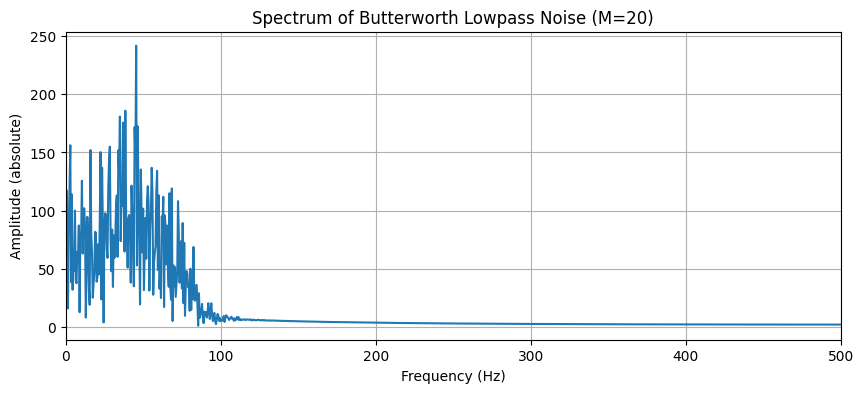

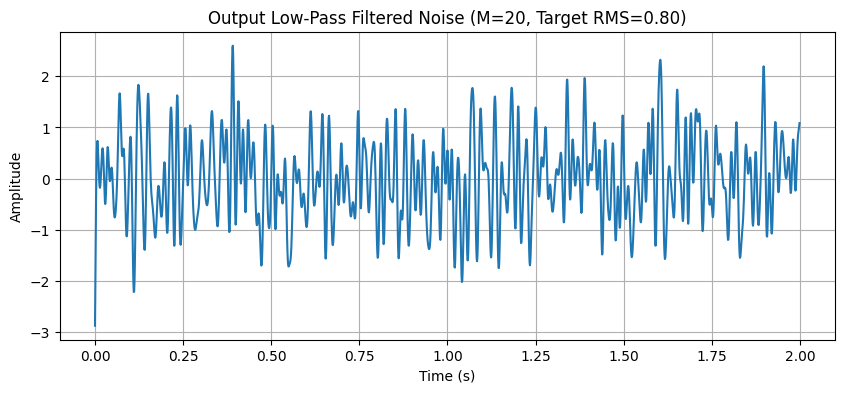

Output LP signal length: 2000
Desired RMS: 0.8000, Achieved RMS: 0.8000



In [66]:

# --- Low-pass example ---
FMIN_LP = 0    # Hz (for low-pass)
FMAX_LP = 80   # Hz
AMPLITUDE_LP = 0.8 # Target RMS
NUM_REALIZATIONS_OUTPUT_LP = 20

print(f"\n--- Generating Butterworth Low-Pass Filtered Noise (Output M={NUM_REALIZATIONS_OUTPUT_LP}) ---")
lp_noise_signal, t_lp_noise = generate_butterworth_filtered_noise(
    FMIN_LP, FMAX_LP, AMPLITUDE_LP, TS_EXAMPLE, DURATION_EXAMPLE,
    NUM_REALIZATIONS_OUTPUT_LP, filter_order=FILTER_ORDER_EXAMPLE
)

plt.figure(figsize=(10, 4)) # Separate figure for time-domain plot
plt.plot(t_lp_noise, lp_noise_signal)
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title(f"Output Low-Pass Filtered Noise (M={NUM_REALIZATIONS_OUTPUT_LP}, Target RMS={AMPLITUDE_LP:.2f})")
plt.grid(True)
plt.show()
print(f"Output LP signal length: {len(lp_noise_signal)}")
achieved_rms_lp = np.sqrt(np.mean(lp_noise_signal**2)) if len(lp_noise_signal) > 0 else 0
print(f"Desired RMS: {AMPLITUDE_LP:.4f}, Achieved RMS: {achieved_rms_lp:.4f}\n")
